# Вычисление значения кусочно линейной функции

Решением задачи линейного программирования мы можем получить значения кусочно-линейных функций.

Нам потребуется линейные решатели, numpy и графика:

In [2]:
from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPArray

import numpy as np

import matplotlib.pyplot as plt

## Прямая задача

Рассмотрим кусочно-линейную функцию такого вида, чтобы она принимала нулевое значение для $x <= 0$ и выпуклой для $x > 0$. Функция заданна на $n$ точках из отрезка $[a,b]$.

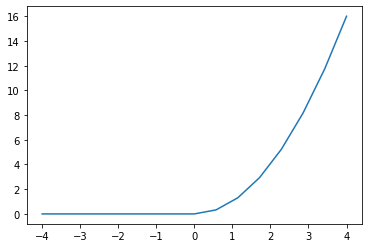

In [18]:
n = 15
a, b = -4, 4
x = np.linspace(a,b,n)
y = np.piecewise(x, [x <= 0, x > 0], 
                [0, lambda x: x**2])
plt.plot(x,y)

Мы будем искать значение $y_0$ для некоторого заданного $x_0$

In [10]:
x_0 = 2

Поиск координаты $y$ при заданных $x$ можно свести к решению следующей задачи ЛП:

$$
\min_{u_i, i=1,\ldots,n} y = \sum_{i=1}^{n} u_i y_i,
$$

при условиях:

$$
\sum_{i=1}^{n} u_i x_i = x_0,\\
\sum_{i=1}^{n} u_i = 1, \\
u_i >= 0, i = 1,\ldots, n.
$$

Для этого сформируем матрицу коэффициентов $A$ для представления ограчничений в матричной форме и вектор $b$:

In [20]:
A = np.vstack([x,np.ones(n)])
A = np.matrix(A)
b = CyLPArray(np.array([x_0, 1]))

После всего этого мы можем спокойно отправить в *cylp* нашу матрицу и решить задачу:

In [22]:
s = CyClpSimplex()
u = s.addVariable('u',n)

s += A*u == b

for i in range(n):
    s += u[i] >= 0

s.optimizationDirection = 'min'
s.objectiveCoefficients = y
s.primal()

'optimal'

Значением функции будет величина скалярного произведения набора оптимизируемых параметров, на соответсвующие точки в таблице значений кусочно-линейной функции

In [31]:
cond = s.primalVariableSolution['u']
x_res = np.dot(cond, x)
y_res = np.dot(cond, y)

print(x_0,x_res)
print(x_0**2, y_res)

2 2.0
4 4.0816326530612255


Выделим в отдельную функцию, процесс, который описан выше: 

In [73]:
def plpf(xs,ys,x_0):
    x,y = xs,ys
    s = CyClpSimplex()
    u = s.addVariable('u',n)

    A = np.vstack([x,np.ones(n)])
    A = np.matrix(A)
    b = CyLPArray(np.array([x_0, 1]))
    
    s += A*u == b

    for i in range(n):
        s += u[i] >= 0
        
    s.optimizationDirection = 'min'
    s.objectiveCoefficients = y
    s.primal()
    cond = s.primalVariableSolution['u']
    y_res = np.dot(cond, y)
    
    return y_res

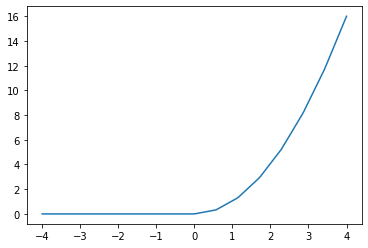

In [85]:
a,b = -4,4
n_res = n*10
x_res = np.linspace(a,b,n_res)
y_res = np.empty(n_res)

for i in range(n_res):
    y_res[i] = plpf(x,y,x_res[i])

plt.plot(x_res, y_res)

Для проверки вычислим величину отклонения приближения, крестиком обозначим те точки, на которых заданно табличное значение:

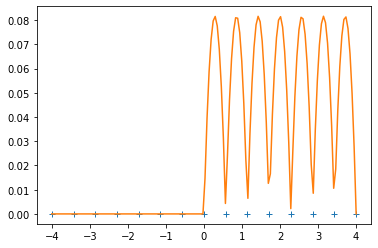

In [93]:
y_test = np.piecewise(x_res, [x_res <= 0, x_res > 0], 
                [0, lambda x: x**2])
plt.plot(x,np.zeros_like(x),'+')
plt.plot(x_res, abs(y_test - y_res))